# PLEASE EXECUTE EACH CELL ONE BY ONE

# Non-Linear SVM

Importing libraries

In [1]:
import pandas as pd
import statistics
import numpy as np
!pip install ipympl
from sklearn import datasets
from mlxtend.plotting.decision_regions import plot_decision_regions
import matplotlib.pyplot as plt
%matplotlib --list
%matplotlib widget




Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


Generating Non-Linear DataSet

In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=100, factor=0.3, noise=0.15, random_state=0)
y_=2*y-1
x_train, x_test, y_train, y_test = train_test_split(X,y_,test_size=0.1)



Non-Linear SVM.

In [3]:
def linear_kernel(x1, x2):
    return x1.T @ x2
def poly_kernel(x1,x2):
   return (np.dot(x1, x2.T) ** 2)


class SVM():
    def __init__(self, kernel, c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        
        
        if self._kernel == 'linear':
            self._k = linear_kernel
            
            
        if self._kernel == 'poly':
            self._k = poly_kernel
        
        
          
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            f1=y1*(e1+self._b)-alpha1*k11-s*alpha2*k12
            f2=y2*(e2+self._b)-alpha2*k22-s*alpha1*k12
            L1=alpha1+s*(alpha2-L)
            H1=alpha1+s*(alpha2-H)
            objL=(L1*f1)+(L*f2)+(0.5*L1*L1*k11)+(0.5*L*L*k22)+(s*L*L1*k12)
            objH=(H1*f1)+(H*f2)+(0.5*H1*H1*k11)+(0.5*H*H*k22)+(s*H*H1*k12)
            if(objL<objH-1e-3):
                a2=L
            elif(objL>objH+1e-3):
                a2=H
                
            else:
                a2=alpha2
            
            #print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True




# Non_Linear_SVM Without sklearn.svm.SVC

TRANING THE DATA!!

In [4]:
model = SVM(kernel='poly',c=1.0)
model.fit(x_train, y_train)

TESTING THE DATA!!



In [5]:
y_predict_1=model.predict(x_test)
print(y_predict_1)

[-1. -1. -1.  1.  1.  1. -1. -1. -1. -1.]


In [6]:
print(y_test)

[-1 -1 -1  1  1  1 -1 -1 -1 -1]


ACCURACY

In [7]:
from sklearn.metrics import accuracy_score
A1=accuracy_score(y_test, y_predict_1)
print(A1)

1.0


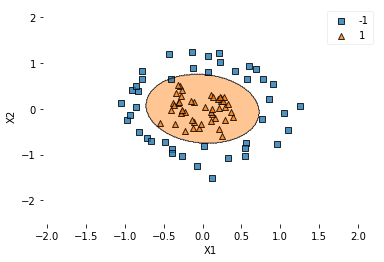

In [8]:
%matplotlib inline
plot_decision_regions(x_train,y_train,clf =model)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Implementation Of linear SVM without sklearn.svm.SVC

In [10]:
model_LINEAR = SVM(kernel='linear',c=5.0)
model_LINEAR.fit(x_train, y_train)

In [12]:
print(f"weights={model_LINEAR._weights}")
print(f"b={model_LINEAR._b}")


weights=[-0.85513518 -1.14999281]
b=-0.6238530506747597


In [14]:
y_predict_LINEAR=model_LINEAR.predict(x_test)
print(y_predict_LINEAR)

[ 1.  1.  1.  1.  1.  1. -1. -1.  1.  1.]


In [16]:
from sklearn.metrics import accuracy_score
A_LINEAR=accuracy_score(y_test, y_predict_LINEAR)
print(A_LINEAR)

0.5


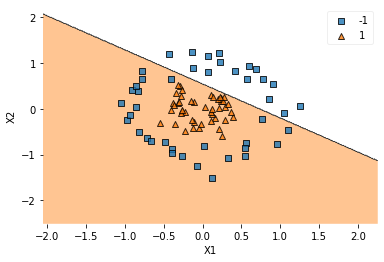

In [17]:
%matplotlib inline
plot_decision_regions(x_train,y_train.astype(np.int32),clf =model_LINEAR)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Implementation Of linear SVM with sklearn.svm.SVC 

In [18]:
from sklearn.svm import SVC
clf1 = SVC(kernel='linear',C=0.5)
clf1.fit(x_train, y_train)
y_predict_2=clf1.predict(x_test)
print(y_predict_2)


[1 1 1 1 1 1 1 1 1 1]


In [19]:
A2=accuracy_score(y_test, y_predict_2)
print(A2)

0.3


/opt/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)


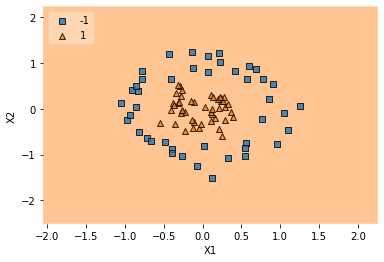

In [20]:
%matplotlib inline
plot_decision_regions(x_train,y_train,clf =clf1,legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

#plt.legend(loc='upper left')



# Implementation Of Non linear SVM with sklearn.svm.SVC 

In [21]:
from sklearn import svm
clf2 = svm.SVC( kernel='poly',degree = 2)
clf2.fit(x_train, y_train)
y_predict_3=clf2.predict(x_test)
print(y_predict_2)

[1 1 1 1 1 1 1 1 1 1]


In [22]:
A3=accuracy_score(y_test, y_predict_3)
print(A3)

1.0


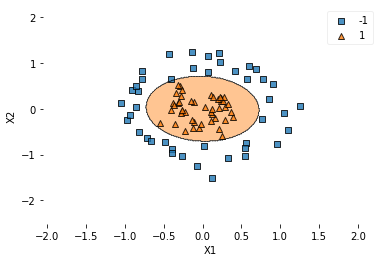

In [23]:
%matplotlib inline
plot_decision_regions(x_train,y_train,clf =clf2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()



# MULTICLASS

Importing lib

In [24]:
import pandas as pd
import statistics
import numpy as np
from sklearn import datasets
from mlxtend.plotting.decision_regions import plot_decision_regions
import matplotlib.pyplot as plt


loading Data

In [25]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
Y=target = iris_dataset.target
classes = pd.unique(target)
no_of_classes= len(classes)


In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(iris_dataset.data,iris_dataset.target,test_size=0.1)



In [27]:
print(y_train)

[0 0 0 1 2 2 1 0 1 0 2 0 2 1 2 0 2 2 2 1 1 2 2 0 1 0 0 0 2 2 0 2 2 0 2 0 2
 1 1 2 1 2 0 1 0 0 2 0 0 2 0 0 1 0 2 2 0 0 0 2 2 1 1 0 1 0 0 0 2 1 2 0 2 1
 1 2 2 1 0 1 1 2 2 1 0 1 1 2 2 0 1 2 0 2 1 1 1 1 0 1 1 0 1 1 2 2 0 1 1 2 2
 0 1 2 1 0 1 0 2 1 2 1 2 1 1 0 2 2 1 0 2 1 1 0 0]


# MULTI CLASS SVM

In [28]:
class MultiClassSvm():
    def individualClass(self,x_train,y_train):
        Classifier1_output=np.zeros([3,x_train.shape[0]])
        for j in range (no_of_classes):
            for i in range(x_train.shape[0]):
                if (y_train[i]==j):
                    Classifier1_output[j,i]=1
                else:
                    Classifier1_output[j,i]=-1
        return Classifier1_output
    
    def predict(self,x):
        y_predict_score=[0,0,0]
        y_predict_score=[model0.predict_score(x),model1.predict_score(x),model2.predict_score(x)]
        w=np.argmax(y_predict_score, axis=0)
        return w
        
        
        
        
        
        
        
                    


    
    







      

# Implementation Of Multi Class Non linear SVM without sklearn.svm.SVC# 

#Fitting the data

In [29]:
multiSVM=MultiClassSvm()
Classifier_output=multiSVM.individualClass(x_train[:,[0,1]],y_train)
#print(Classifier_output)

In [30]:
model0=SVM(kernel='poly',c=1.0)
model0.fit(x_train[:,[0,1]], Classifier_output[0])

In [31]:
model1= SVM(kernel='poly',c=1.0)
model1.fit(x_train[:,[0,1]], Classifier_output[1])

In [32]:
model2= SVM(kernel='poly',c=1.0)
model2.fit(x_train[:,[0,1]], Classifier_output[2])

Predicting 

In [33]:
y=multiSVM.predict(x_test[:,[0,1]])
print(y)

[2 0 0 1 0 1 1 0 1 1 2 0 0 0 2]


In [34]:
print(y)
print(y_test)

[2 0 0 1 0 1 1 0 1 1 2 0 0 0 2]
[1 0 0 2 0 1 2 0 2 1 1 0 1 0 2]


In [35]:
A3=accuracy_score(y_test, y)
print(A3)

0.6


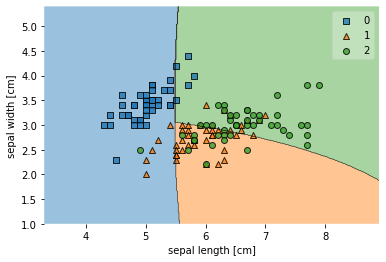

In [36]:
%matplotlib inline
plot_decision_regions(x_train[:,[0,1]],y_train,clf =multiSVM)
plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.show()

# Implementation Of Multi Class Non linear SVM with sklearn.svm.SVC


In [37]:
from sklearn import svm
clf4 = svm.SVC( kernel='poly',degree=2)
clf4.fit(x_train[:,[0,1]], y_train)
y_predict_4=clf4.predict(x_test[:,[0,1]])
print(y_predict_4)

[1 0 0 1 0 1 1 0 1 1 2 0 1 0 2]


In [38]:
A3=accuracy_score(y_test, y_predict_4)
print(A3)

0.7333333333333333


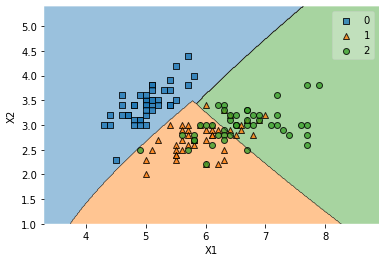

In [39]:
%matplotlib inline
plot_decision_regions(x_train[:,[0,1]],y_train,clf =clf4)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()



# Implementation Of Multi Class linear SVM without sklearn.svm.SVC

[2 0 0 2 0 1 1 0 1 1 2 0 0 0 2]
0.6666666666666666


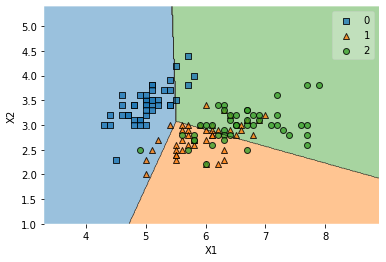

In [40]:

multiSVM1=MultiClassSvm()
model0=SVM(kernel='linear',c=1.0)
model0.fit(x_train[:,[0,1]], Classifier_output[0])
model1= SVM(kernel='linear',c=1.0)
model1.fit(x_train[:,[0,1]], Classifier_output[1])
model2= SVM(kernel='linear',c=1.0)
model2.fit(x_train[:,[0,1]], Classifier_output[2])
y1=multiSVM.predict(x_test[:,[0,1]])
print(y1)
A_3=accuracy_score(y_test, y1)
print(A_3)
%matplotlib inline
plot_decision_regions(x_train[:,[0,1]],y_train,clf =multiSVM1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()




# Implementation Of Multi Class linear SVM with sklearn.svm.SVC

In [41]:
from sklearn import svm
clf5 = svm.SVC( kernel='linear')
clf5.fit(x_train[:,[0,1]], y_train)
y_predict_5=clf5.predict(x_test[:,[0,1]])
print(y_predict_5)

[1 0 0 2 0 1 1 0 1 1 2 0 1 0 2]


In [42]:
A4=accuracy_score(y_test, y_predict_5)
print(A4)

0.8


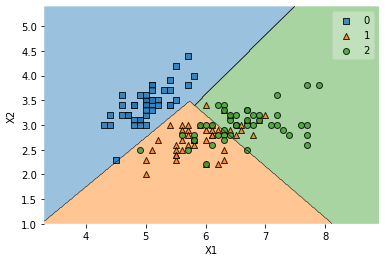

In [43]:
%matplotlib inline
plot_decision_regions(x_train[:,[0,1]],y_train,clf =clf5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

